In [ ]:
import tensorflow as tf
keras = tf.keras
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
last_conv_layer_name = "block14_sepconv1_act"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
model_builder = keras.applications.xception.Xception

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

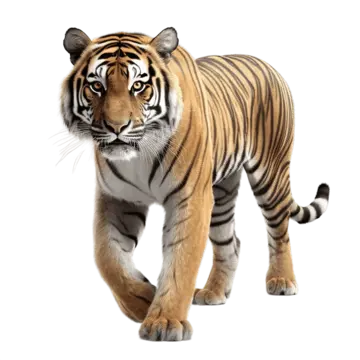

In [ ]:
# The local path to our target image
img_path = '/content/drive/MyDrive/GradCAM/tigre.png'


display(Image(img_path))


In [ ]:
img_size = (299, 299)

In [ ]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n02129604', 'tiger', 9.145111)]


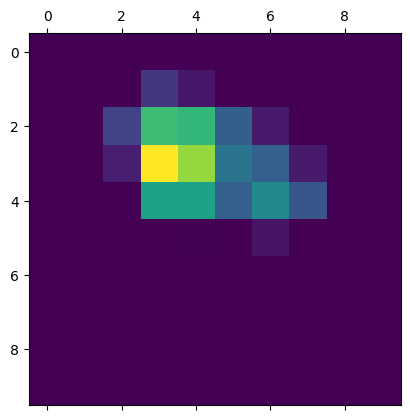

In [ ]:
img_path = '/content/drive/MyDrive/GradCAM/tigre.png'
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-12-a3ac41a0132f>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


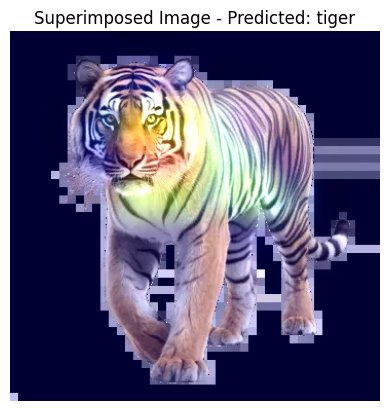

In [ ]:
# Superpose the heatmap on original image

# Load the original image
img = keras.preprocessing.image.load_img(img_path)

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = plt.cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]

# Create an image with RGB colorized heatmap
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.size[0], img.size[1]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap) / 255

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + np.array(img) / 255

fig, ax = plt.subplots()

ax.imshow(superimposed_img)
ax.axis('off')
ax.set_title('Superimposed Image - Predicted: {}'.format(decode_predictions(preds, top=1)[0][0][1]))
plt.show()

In [ ]:

def get_grad_heatmap(conv_layer_name):
    # Print what the top predicted class is
    preds = model.predict(img_array)
    print("Predicted:", decode_predictions(preds, top=1)[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, conv_layer_name)


    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]

    # Create an image with RGB colorized heatmap
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.size[0], img.size[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap) / 255

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + np.array(img) / 255

    return superimposed_img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


<ipython-input-13-a224935bdca5>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted: [('n02129604', 'tiger', 9.145111)]


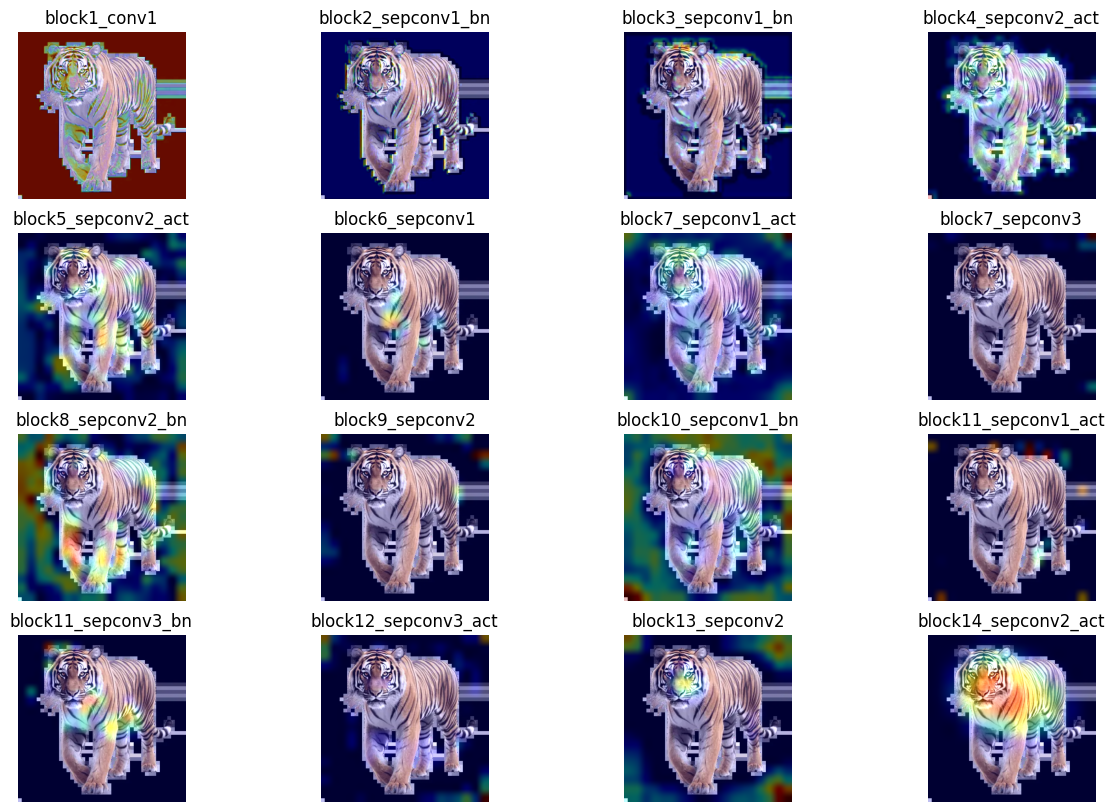

In [ ]:
# Get all "*conv{n}_act" like layers in model
conv_layers = [layer.name for layer in model.layers if 'conv' in layer.name]
num_layers = len(conv_layers)

# Generar 16 índices únicos de manera uniforme
amm = 16
indices = np.linspace(0, num_layers - 1, amm, dtype=int)
fig, axes = plt.subplots(int(np.sqrt(amm)), int(np.sqrt(amm)), figsize=(15, 10))

for ax, i in zip(axes.flatten(), indices):
    heatmap = get_grad_heatmap(conv_layers[i])
    ax.imshow(heatmap)
    ax.axis('off')
    ax.set_title(conv_layers[i])